#Problème 1:





Dans ce problème, il s'agit de reconstruire un champ spatialisé cible à partir d'un prédicteur spatialisé et d'observations ponctuelles.  
Dans la première partie, on adapte simplement la procédure de régression pixel à pixel standard au cas où les données cibles ne sont renseignées qu'en quelques pixels (observations "ponctuelles").\
Dans la seconde partie, on entraîne un réseau à prendre les deux types de données, champ spatialisé et observations ponctuelles, en entrée pour reconstruire au mieux la cible complète.

**NB**: Il vaut mieux traiter les deux parties dans l'ordre.

In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import numpy as np
import matplotlib.pyplot as plt

In [6]:


import torch
import numpy as np
from random import randint
import matplotlib.pyplot as plt
import os
#############################################################
#pour la visualisation des images ###########################
#############################################################

def voir_mat(data2, fig, min_scale=-10,max_scale=70):

    ax = fig.add_subplot(1,1,1)
    ax.set_aspect('equal')
    plt.imshow(data2, interpolation='nearest', cmap=plt.cm.rainbow) #cmap=plt.cm.ocean)
    plt.clim(min_scale,max_scale)
    plt.colorbar()
    plt.show()

def voir_tens(image, fig, min_scale=-1,max_scale=1):
    im=image[0,0,:,:].numpy()
    ax = fig.add_subplot(1,1,1)
    ax.set_aspect('equal')
    plt.imshow(im, interpolation='nearest',  cmap=plt.cm.rainbow) #cmap=plt.cm.ocean)
    plt.clim(min_scale,max_scale)
    plt.colorbar()
    plt.show()

def conc(image1,image2,dim=3):
    return torch.cat((image1,image2), dim) #, out=None)

def multi_conc(L,dim=1,ecart=5, min_scale=0.5):
    image1=L[0]
    for i in range(1, len(L)):
        if dim==1:
            sep=  min_scale + 0*image1[:,0:ecart]
        elif dim==0:
            sep=  min_scale + 0*image1[0:ecart,:]
        image1=conc(image1,sep,dim)
        image2=L[i]
        image1=conc(image1,image2,dim=dim)
    return image1

def images_from_tenseur(tens, k=0):
    len_batch=tens.shape[0]
    L=[]
    for i in range(len_batch):
        L.append(tens[i,k,:,:])
    return L

def voir_batch2D(tens, nx, fig,k=0, min_scale=-10,max_scale=1):
    s = 0.5*(min_scale + max_scale)
    L=images_from_tenseur(tens,k)
    image1=multi_conc(L[0:nx],dim=1, min_scale=s)
    for i in range(1,int(len(L)/nx)):
        image2=multi_conc(L[i*nx:(i+1)*nx],dim=1, min_scale=s)
        image1=multi_conc([image1,image2],dim=0, min_scale=s)
    voir_mat(image1, fig, min_scale,max_scale)


#############################################################
#pour la génération des images    ###########################
#############################################################

def simu_rec(image, L,l,  fields=0):
    channels,size,size2=image.size()
    rec= torch.zeros(channels,size,size2)
    #out = 0*(image.clone())
    vertical=np.random.binomial(1,0.5)==1
    if vertical:
        width=l
        height=L
    else:
        width=L
        height=l

    top=randint(0, size-height)
    left=randint(0, size-width)
    rec[fields,top:top+height,left:left+width]=  np.random.uniform(0,0.4)   #0.1
    image=image + rec
    return image

def simu_noisy_rec(image, L,l,  fields=0):
    channels,size,size2=image.size()
    rec= torch.zeros(channels,size,size2)
    #out = 0*(image.clone())
    vertical=np.random.binomial(1,0.5)==1
    if vertical:
        width=l
        height=L
    else:
        width=L
        height=l

    top=randint(0, size-height)
    left=randint(0, size-width)
    rec[fields,top:top+height,left:left+width]= np.random.uniform(0,0.4)  #0.1
    noise=torch.randn(channels,size,size2)
    noise=noise*(noise>0).float()
    rec=noise*rec
    image=image + rec
    return image

def simu_disc(image, f, radius=15, fields=0 ):  #radial decrease function  #or 12
    channels,size,size2=image.size()
    center=np.array([randint(radius, size-radius) , randint(radius, size-radius) ])
    npdisc= f( ((np.arange(0,64)*np.ones([size,size])) - center[0])**2 + (np.transpose(np.arange(0,64)*np.ones([size,size]))-center[1])**2  , radius)
    npdisc=np.random.uniform(0.6,1.) * npdisc  #variation on intensity
    image[fields,:,:] = image[fields,:,:] + torch.from_numpy(npdisc).float()   #matrice des distances < rayon
    return image

def simu_disc_with_cond(image, f, radius=15, fields=0, f2 = lambda a,x  : ((np.sin(3.1 * a/x**2)))*(a < x**2) ):  #radial decrease function  #or 12
    channels,size,size2=image.size()
    center=np.array([randint(radius-5, size-radius+2) , randint(radius-2, size-radius+5) ])
    npdisc= f( ((np.arange(0,64)*np.ones([size,size])) - center[0])**2 + (np.transpose(np.arange(0,64)*np.ones([size,size]))-center[1])**2  , radius)
    npdisc=np.random.uniform(0.6,1.) * npdisc  #variation on intensity
    image[0,:,:] = image[0,:,:] + torch.from_numpy(npdisc).float()   #matrice des distances < rayon
    if (radius >= 10) and (radius <= 14):
        npdon = f2( ((np.arange(0,64)*np.ones([size,size])) - center[0])**2 + (np.transpose(np.arange(0,64)*np.ones([size,size]))-center[1])**2  , radius)
        image[1,:,:] = image[1,:,:] + torch.from_numpy(npdon).float()**2
    return image


def simu_square(image, f, diag=15, fields=0 ):  #radial decrease function  #or 12
    channels,size,size2 = image.size()
    center=np.array([randint(diag, size-diag) , randint(diag, size-diag) ])

    npsquare = f(  np.abs(np.arange(0,64)*np.ones([size,size]) - center[0]) + \
                   np.abs(np.transpose(np.arange(0,64)*np.ones([size,size]))-center[1]), diag)
#    npsquare = np.abs(np.arange(0,64)*np.ones([size,size]) - center[0])
    npsquare = np.random.uniform(0.6,1.) * npsquare  #variation on intensity
    image[fields,:,:] = image[fields,:,:] + torch.from_numpy(npsquare).float()   #matrice des distances < rayon
    return image


def plot_pairs(image, f = lambda x : x**2):
    horizontal = (torch.randint(0,2,(1,)) > 0.5).item()
#    print(horizontal)
    dist = torch.randint(1,32, (1,)).item()
    if horizontal :
        ordo = torch.randint(0, 64, (1,)).item()
        absi = torch.randint(0, 64 - dist, (1,)).item()
        image[1, ordo, absi:(absi + dist + 1)] \
            += 0.1 + torch.mean(f(image[0, ordo, absi:(absi + dist + 1)]))
    else :
        ordo = torch.randint(0, 64 - dist, (1,)).item()
        absi = torch.randint(0, 64, (1,)).item()
        image[1, ordo:ordo+dist+1, absi] \
            += 0.1 + torch.mean(f(image[0, ordo:ordo+dist+1, absi]))
    return image


def generate_noise(image, lambda_rec=0.001 ,lambda_noisy_rec = 0.001, lambda_disc = 0.001, lambda_square = 0., pola=[0,0.5,0.1]):
    for k in range(np.random.poisson(lambda_disc*64*64)):
        r = randint(5,10)
        image=simu_disc(image, lambda a,x  : (0.39 - 0.36*a/x**2)*(a < x**2) ,radius = r)  #0.47 pour avoir 40 dB
    for k in range(np.random.poisson(lambda_square*64*64)):
        r = randint(5,10)
        image=simu_square(image, lambda a,x  : (0.5 - 0.45*a/x)*(a < x) , diag = r)  #0.47 pour avoir 40 dB
#        print(r)

    for i in range(np.random.poisson(lambda_rec*64*64)):
        L=randint(20,50)
        l=randint(2,10)
        image= simu_rec(image,L,l)
    for j in range(np.random.poisson(lambda_noisy_rec*64*64)):
        L=randint(10,30)
        l=randint(10,30)
        image= simu_noisy_rec(image,L,l)
        # 0.3*np.exp(-0.1 * a/x)*(a < x**2)  #image=simu_disque(image, lambda a,x  : 1.0*(a < x**2)  )
    if pola[0]==1:      #add a pseudo pola field
        image_pola = generate_pola(image,pola)
        image=torch.cat([image,image_pola],dim=0)
    return image


def generate_noise_with_cond(image, lambda_rec=0.001 ,lambda_noisy_rec = 0.001, lambda_disc = 0.001, lambda_square = 0., pola=[0,0.5,0.1]):
    for k in range(np.random.poisson(lambda_disc*64*64)):
        r = randint(6,18)
        image=simu_disc_with_cond(image, lambda a,x  : (0.39 - 0.36*a/x**2)*(a < x**2) ,radius = r)  #0.47 pour avoir 40 dB
    for k in range(np.random.poisson(lambda_square*64*64)):
        r = randint(5,10)
        image=simu_square(image, lambda a,x  : (0.5 - 0.45*a/x)*(a < x) , diag = r)  #0.47 pour avoir 40 dB
#        print(r)

    for i in range(np.random.poisson(lambda_rec*64*64)):
        L=randint(20,50)
        l=randint(2,10)
        image= simu_rec(image,L,l)
    for j in range(np.random.poisson(lambda_noisy_rec*64*64)):
        L=randint(10,30)
        l=randint(10,30)
        image= simu_noisy_rec(image,L,l)
        # 0.3*np.exp(-0.1 * a/x)*(a < x**2)  #image=simu_disque(image, lambda a,x  : 1.0*(a < x**2)  )
    return image


def generate_noise_and_pairs(image, lambda_pairs = 0.01, lambda_rec=0.001 ,lambda_noisy_rec = 0.001, lambda_disc = 0.001, lambda_square = 0., pola=[0,0.5,0.1]):
    for k in range(np.random.poisson(lambda_disc*64*64)):
        r = randint(5,10)
        image=simu_disc(image, lambda a,x  : (0.39 - 0.36*a/x**2)*(a < x**2) ,radius = r)  #0.47 pour avoir 40 dB
    for k in range(np.random.poisson(lambda_square*64*64)):
        r = randint(5,10)
        image=simu_square(image, lambda a,x  : (0.5 - 0.45*a/x)*(a < x) , diag = r)  #0.47 pour avoir 40 dB
#        print(r)

    for i in range(np.random.poisson(lambda_rec*64*64)):
        L=randint(20,50)
        l=randint(2,10)
        image= simu_rec(image,L,l)
    for j in range(np.random.poisson(lambda_noisy_rec*64*64)):
        L=randint(10,30)
        l=randint(10,30)
        image = simu_noisy_rec(image,L,l)
        # 0.3*np.exp(-0.1 * a/x)*(a < x**2)  #image=simu_disque(image, lambda a,x  : 1.0*(a < x**2)  )
    # on ajoute le deuxième canal où les échanges entre signaux seront
    # représentés

    image2 = torch.zeros([1,64, 64])
    image = torch.cat([image,image2], dim = 0 )

    for j in range(np.random.poisson(lambda_pairs*64*64)):
        image = plot_pairs(image)

    return image


def make_image(rec, noisy_rec ,disc,square=0., pola=[0]):
    image=torch.zeros([1,64, 64])
    image = generate_noise(image, lambda_rec=rec, lambda_noisy_rec = noisy_rec,lambda_disc = disc, lambda_square = square, pola= pola)
    return image

def make_image_with_cond(rec, noisy_rec ,disc,square=0., pola=[0]):
    image = torch.zeros([2, 64, 64])
    image = generate_noise_with_cond(image, lambda_rec=rec, lambda_noisy_rec = noisy_rec,lambda_disc = disc, lambda_square = square, pola= pola)
    return image

def make_batch(batch_size, rec, noisy_rec ,disc, square=0., pola=[0] ):
    out = make_image(rec, noisy_rec ,disc , square, pola ).unsqueeze(0)
    for i in range(batch_size-1):
        new=make_image(rec, noisy_rec ,disc, square, pola).unsqueeze(0)
        out=torch.cat((out,new), dim=0)
    return out

def make_batch_with_cond(batch_size, rec, noisy_rec ,disc, square=0.):
    out = make_image_with_cond(rec, noisy_rec ,disc , square).unsqueeze(0)
    for i in range(batch_size-1):
        new=make_image_with_cond(rec, noisy_rec ,disc, square).unsqueeze(0)
        out=torch.cat((out,new), dim=0)
    return out

def make_image_with_pairs(rec, freq_integrated_signals, noisy_rec ,disc,square=0., pola=[0]):
    image=torch.zeros([1,64, 64])
    image = generate_noise_and_pairs(image, lambda_pairs = freq_integrated_signals, lambda_rec=rec, lambda_noisy_rec = noisy_rec,lambda_disc = disc, lambda_square = square, pola= pola)
    return image

def make_batch_with_pairs(batch_size, freq_integrated_signals, rec, noisy_rec, disc, square=0., pola=[0] ):
    out=make_image_with_pairs(rec, freq_integrated_signals, noisy_rec ,disc , square, pola ).unsqueeze(0)
    for i in range(batch_size - 1):
        new=make_image_with_pairs(rec, freq_integrated_signals, noisy_rec, disc, square, pola).unsqueeze(0)
        out=torch.cat((out,new), dim = 0)
    return out


##############################################################################################
################################   UNet (parties)#############################################
import torch
import torch.nn as nn
import torch.nn.functional as F

class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x

#Given transposed=1, weight[1024, 256, 2, 2], so expected input[64, 512, 4, 4] to have 1024 channels, but got 512 channels instead

class Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=False):
        super(Up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear')#nn.UpsamplingBilinear2d(scale_factor=2)
        else:
            self.up = nn.ConvTranspose2d(in_ch, in_ch, kernel_size=2, stride=2)

        self.conv = double_conv(2*in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffX = x1.size()[2] - x2.size()[2]
        diffY = x1.size()[3] - x2.size()[3]
        x2 = F.pad(x2, (diffX // 2, int(diffX / 2),
                        diffY // 2, int(diffY / 2)))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)


    def forward(self, x):
        x = self.conv(x)
        return x


###############################################################################################################################################
########################################Montage Unet ################################################################################

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes,size=64):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, size)
        self.down1 = Down(size, 2*size)
        self.down2 = Down(2*size, 4*size)
        self.down3 = Down(4*size, 8*size)
        self.down4 = Down(8*size, 8*size)
        self.up1 = Up(8*size, 4*size)
        #self.up12 = up(16*size, 4*size)
        self.up2 = Up(4*size, 2*size)
        #self.up22 = up(8*size, 2*size)
        self.up3 = Up(2*size, size)
        #self.up32 = up(4*size, size)
        self.up4 = Up(size, size)
        #self.up42 = up(2*size, size)
        self.outc = outconv(size, n_classes)
        self.outc2 = outconv(size, n_classes)
        self.n_classes=n_classes

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        del x4, x5
        x = self.up2(x, x3)
        del x3
        x = self.up3(x, x2)
        del x2
        x = self.up4(x, x1)
        del x1
        x = self.outc(x)
        return   x

#%
class UNet_cal(nn.Module):
    def __init__(self, n_channels, n_classes,size=64):
        super(UNet_cal, self).__init__()
        self.inc = inconv(n_channels, size)
        self.down1 = Down(size, 2*size)
        self.down2 = Down(2*size, 4*size)
        self.down3 = Down(4*size, 8*size)
        self.down4 = Down(8*size, 8*size)
        self.up1 = Up(8*size, 4*size)
        #self.up12 = up(16*size, 4*size)
        self.up2 = Up(4*size, 2*size)
        #self.up22 = up(8*size, 2*size)
        self.up3 = Up(2*size, size)
        #self.up32 = up(4*size, size)
        self.up4 = Up(size, size)
        #self.up42 = up(2*size, size)
        self.outc = outconv(size, n_classes)
        self.outc2 = outconv(size, n_classes)
        self.n_classes=n_classes
        #Pour la partie étalonnage :
        self.cal1 = nn.Linear(1,5)
        self.cal2 = nn.Linear(5,5)
        self.cal3 = nn.Linear(5,1)
        self.r = nn.ReLU()

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        del x4, x5
        x = self.up2(x, x3)
        del x3
        x = self.up3(x, x2)
        del x2
        x = self.up4(x, x1)
        del x1
        x = self.outc(x)

        # PArtie calibration :
        z = x.transpose(1, 3)
        z = self.r(self.cal1(z))
        z = self.r(self.cal2(z))
        z = torch.tan(self.cal3(z))
        z = z.transpose(1, 3)

        return   x, z



#nn.Tanh()

##############################################################################################
################################       spécifique au TP     ##################################

def gen(n):  #exercice 1 partie 1
  target = make_batch(n, rec = 0., noisy_rec= 0., disc = 0.002)
  noise =  make_batch(n, rec = 0.0003, noisy_rec= 0.0003, disc = 0.)
  return  target + noise, target     #bruit additif trivial

def gen_noise2noise(n):
  target = make_batch(n, rec = 0., noisy_rec= 0., disc = 0.002)
  noise1 =  make_batch(n, rec = 0.0005, noisy_rec= 0.0005, disc = 0.)
  noise2 =  make_batch(n, rec = 0.0005, noisy_rec= 0.0005, disc = 0.)
  return  target + noise1, target + noise2

def gen1_NES(n):
  noisy_image = make_batch(n, rec = 0.0003, noisy_rec= 0.0003, disc = 0.002)
  return  noisy_image

def gen2_NES(n):
  noise1 =  make_batch(n, rec = 0.0003, noisy_rec= 0.0003, disc = 0.)
  return  noise1


def gen_proba(n):
  target1 = make_batch(n, rec = 0., noisy_rec= 0., disc = 0.001)
  m1 = torch.normal(target1**2, 0.2*target1)
  input = target1
  target =   m1
  return  input, target

def gen_ponct(n, p = 0.01):
  input = make_batch(n, rec = 0., noisy_rec= 0., disc = 0.001)
  fulltarget = 2*input**2
  sb = torch.bernoulli(0*fulltarget + p)         # En moyenne,2% des pixels sont couverts par une mesure ponctuelle

  #cible fragmentaire
  target = fulltarget*(sb) + (-1)*(1 - sb)

  return  input, target, fulltarget




def gen1(n, p = 0.02):
  target1 = make_batch(n, rec = 0.001, noisy_rec= 0., disc = 0.)
  target2 = make_batch(n, rec = 0., noisy_rec= 0., disc = 0.001)
  s1 = 0.4*target1  #premier type de cellule: signal-cible faible
  s2 = 2*target2**2  #second type: signal-cible fort
  sb = torch.bernoulli(0*target1 + p)         # En moyenne,2% des pixels sont couverts par une mesure ponctuelle
  noise =  make_batch(n, rec = 0., noisy_rec= 0.0002, disc = 0.)

  input = target1 + target2 + noise
  fulltarget =   s1 + s2

  #cible fragmentaire
  target = fulltarget*sb + (-1)*(1 - sb)

  return  input, target, fulltarget


def gen2(n, p = 0.02):
  target1 = make_batch(n, rec = 0., noisy_rec= 0., disc = 0.001)
  target2 = make_batch(n, rec = 0., noisy_rec= 0., disc = 0.001)
  # target3 = make_batch(n, rec = 0.001, noisy_rec= 0., disc = 0.)
  s1 = 0.4*target1  #premier type de cellule: signal-cible faible
  s2 = 1.6*target2  #second type: signal-cible fort
  sb = torch.bernoulli(0*target1 + p)         # En moyenne,2% des pixels sont couverts par une mesure ponctuelle

  #noise =  make_batch(n, rec = 0.0003, noisy_rec= 0.0003, disc = 0.)

  input = target1 + target2 #+ target3
  fulltarget =   s1 + s2

  #cible fragmentaire
  target = fulltarget*sb + (-1)*(1 - sb)

  return  input, target, fulltarget


  def simu_1disc(image, mean, sigma, f, radius=15, fields=0 ):  #radial decrease function  #or 12
    channels,size,size2=image.size()
    center=np.array([randint(radius, size-radius) , randint(radius, size-radius) ])
    npdisc= f( ((np.arange(0,64)*np.ones([size,size])) - center[0])**2 + (np.transpose(np.arange(0,64)*np.ones([size,size]))-center[1])**2  , radius)
    npdisc = torch.from_numpy(npdisc).float()
    noise = torch.randn(channels,size,size2)
    npdisc = (mean + sigma*noise)* npdisc   #bruitage du disque
    image[fields,:,:] = image[fields,:,:] + npdisc   #matrice des distances < rayon
    return image

def make_image2():
    image=torch.zeros([1,64, 64])
    f = lambda a,x  : (a < x**2)
    r = randint(5,10)
    rplus = randint(5,8)
    md0= np.random.uniform(0,1)
    md1= np.random.uniform(0,1)
    image=simu_1disc(image, md0, 0, f  ,radius = r)
    image=simu_1disc(image, md1, 0, f  ,radius = r+rplus)
#    L=randint(50,60)
#    l=randint(2,10)
#    image= simu_rec(image,L,l)
    return image.unsqueeze(0), torch.tensor(md0).reshape((1,1))

def gen_paires(batch_size):

    out0,y0=make_image2()
    out1,y1=make_image2()


    for i in range(batch_size-1):
        new0,newy0=make_image2()
        out0=torch.cat((out0,new0), dim=0)
        y0=torch.cat((y0,newy0), dim=0)
        new1,newy1=make_image2()
        out1=torch.cat((out1,new1), dim=0)
        y1=torch.cat((y1,newy1), dim=0)
    return out0,out1, (y0<y1).int(), y0, y1


def gen_image_with_integrated_signals(batch_size, p):
    freq_integrated_signals = 0.005
    image = make_batch_with_pairs(batch_size, freq_integrated_signals, 0, 0 ,0.001, square=0., pola=[0] )
    full_target = image[:,[0],:,:] #2*x**2
    sb = torch.bernoulli(0*full_target + p)         # En moyenne,2% des pixels sont couverts par une mesure ponctuelle
    #cond (ex. cible fragmentaire)
    partial_target = full_target*sb + (-1)*(1 - sb)
    integrated_signals = image[:,[1],:,:]

    return full_target, partial_target, integrated_signals

#% Générations des alphas, betas :
"""
if 'alphas.pt' not in os.listdir('data'):
    alphas = 0.1 + 2*0.1*torch.rand((1,1,64,64))
    betas = -1 + 2*torch.rand((1,1,64,64))
    torch.save(alphas,'alphas.pt')
    torch.save(betas,'betas.pt')

alphas = torch.load('data/alphas.pt')
betas = torch.load('data/betas.pt')
"""

def gen_inputs_and_uncal_measurements_train(batch_size, p=0.2):
    image = make_batch_with_cond(batch_size, 0.0003, 0.0003 ,0.0007, square=0.)
    inputs = image[:,[0],:,:]
    correct_targets = image[:,[1],:,:]
    # sensor2020 = correct_targets[:,0,20,20]
    # sensor4040 = correct_targets[:,0,40,40]
    full_uncal_measurements = betas + alphas * correct_targets
    sb = torch.bernoulli(0*full_uncal_measurements + p)         # En moyenne,2% des pixels sont couverts par une mesure ponctuelle
    #cond (ex. cible fragmentaire)
    partial_uncal_measurements = full_uncal_measurements*sb + (-100)*(1 - sb)
    partial_uncal_measurements[:,0,20,20] = correct_targets[:,0,20,20]
    partial_uncal_measurements[:,0,40,40] = correct_targets[:,0,40,40]
    return inputs, partial_uncal_measurements


def gen_inputs_and_uncal_measurements_test(batch_size, p=0.2):
    image = make_batch_with_cond(batch_size, 0.0003, 0.0003 ,0.0007, square=0.)
    inputs = image[:,[0],:,:]
    correct_targets = image[:,[1],:,:]
    # sensor2020 = correct_targets[:,0,20,20]
    # sensor4040 = correct_targets[:,0,40,40]
    full_uncal_measurements = betas + alphas * correct_targets
    sb = torch.bernoulli(0*full_uncal_measurements + p)         # En moyenne,2% des pixels sont couverts par une mesure ponctuelle
    # cond (ex. cible fragmentaire)
    partial_uncal_measurements = full_uncal_measurements*sb + (-100)*(1 - sb)
    partial_uncal_measurements[:,0,20,20] = correct_targets[:,0,20,20]
    partial_uncal_measurements[:,0,40,40] = correct_targets[:,0,40,40]
    return inputs, corrects_targets, partial_uncal_measurements



def gen_inputs_and_uncal_measurements(batch_size, p=0.2):

    image = make_batch_with_cond(batch_size, 0.0003, 0.0003 ,0.0007, square=0.)
    inputs = image[:,[0],:,:]
    correct_targets = image[:,[1],:,:]
    sensor2020 = correct_targets[:,0,20,20]
    sensor4040 = correct_targets[:,0,40,40]
    full_uncal_measurements = betas + alphas * correct_targets

    sb = torch.bernoulli(0*full_uncal_measurements + p)         # En moyenne,2% des pixels sont couverts par une mesure ponctuelle
    #cond (ex. cible fragmentaire)
    partial_uncal_measurements = full_uncal_measurements*sb + (-100)*(1 - sb)

    return inputs, correct_targets, partial_uncal_measurements, sensor2020, sensor4040



## Partie I : régression sur une cible incomplète

La fonction *gen1* permet d'échantillonner des données d'apprentissage.\
Le paramètre *p* représente la proportion de pixels au niveau desquels les observations ponctuelles sont disponibles. Ces observations ponctuelles, contenues dans le deuxième tenseur fourni par *gen1*, sont positives ou nulles. Les pixels où elles manquent sont associés à la valeur -1.\
Le troisième tenseur correspond à la cible complète (cas idéal où *p*=1). C'est elle qu'on cherche à prédire.

**NB**:
- le deuxième tenseur est une version incomplète du troisième tenseur.
- *gen1* peut être considéré comme un échantillonneur parfait des données d'apprentissage. Il ne produit jamais deux fois les mêmes images.

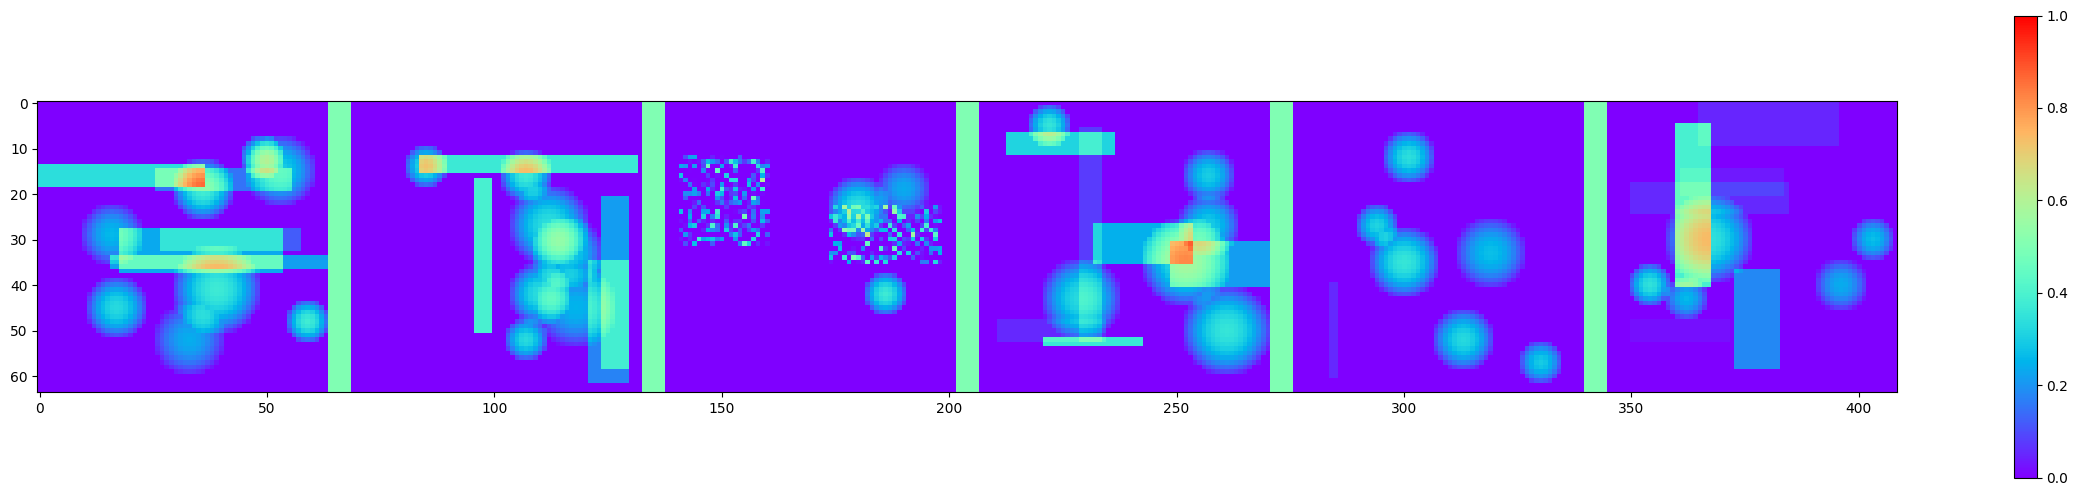

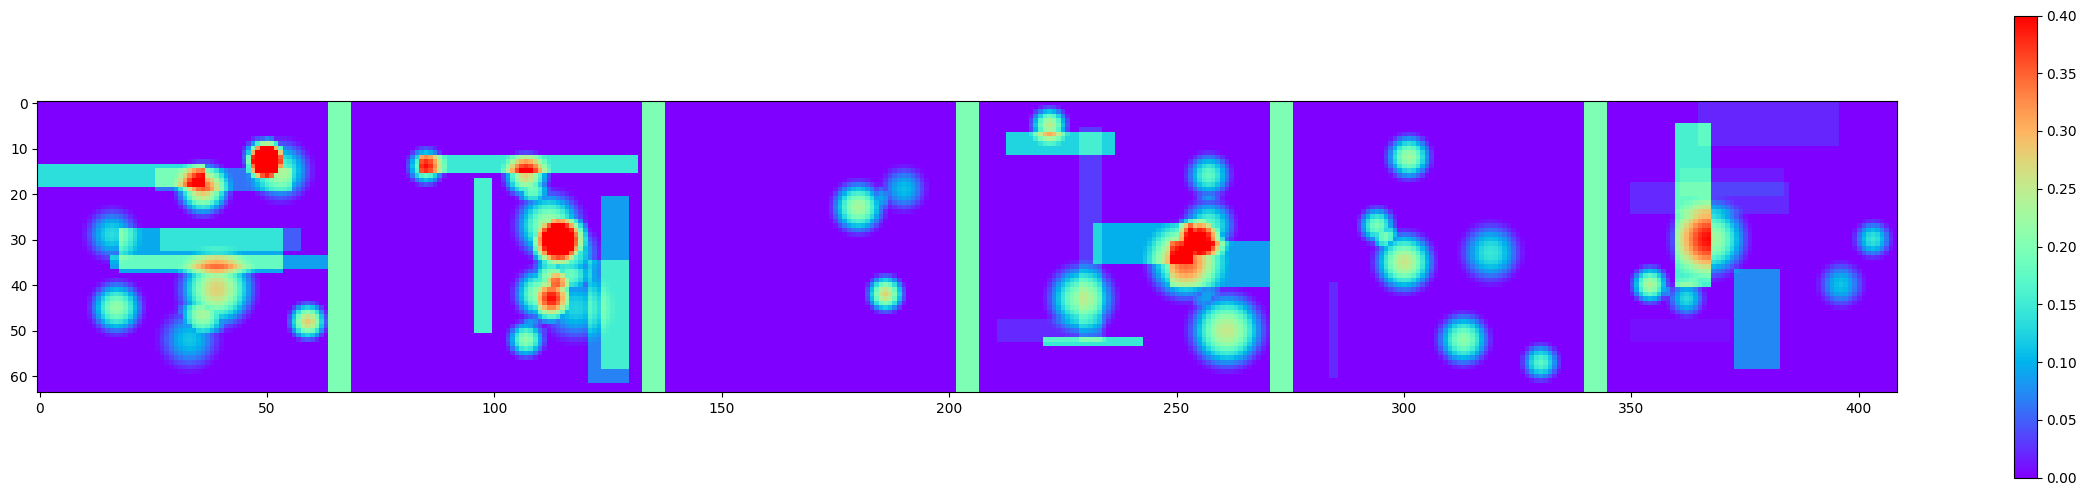

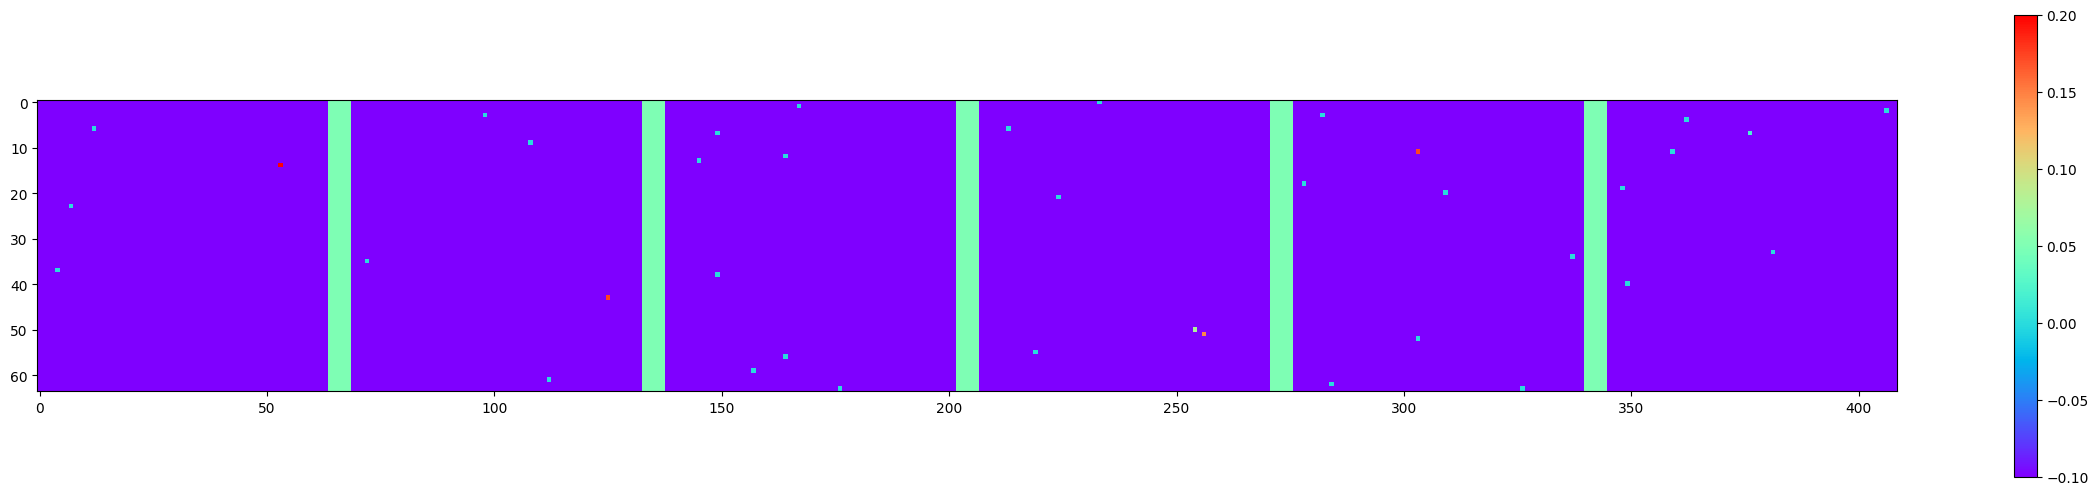

In [8]:
input,  target, fulltarget  = gen1(6,p=0.002)

# input: prédicteur spatialisé
fig0 = plt.figure(0, figsize=(30, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0, max_scale=1)

# fulltarget: cible complète, qu'on ne peut pas utiliser pour l'apprentissage
fig1 = plt.figure(1, figsize=(30, 6))
voir_batch2D(fulltarget, 6, fig1, k=0, min_scale=0, max_scale=0.4)

# target: cible incomplète
fig2 = plt.figure(2, figsize=(30, 6))
voir_batch2D(target, 6, fig2, k=0, min_scale=-0.1, max_scale=0.2)

**Q1** Pour entraîner un réseau de neurones sur des cibles incomplètes, on définit la fonction de coût *masked_MAE*.
Préciser le rôle du tenseur *mask*. Tester le bon fonctionnement de *masked_MAE* à l'aide d'un batch généré par *gen1*.
       


In [9]:
def masked_MAE(output, target, mask):
  return (torch.abs(output-target))[mask].mean()

In [10]:
input,target,_ = gen1(6,p=0.002)

# prenons un output de la même dimension que l'entrée:
output = 0 * input + 1

# définissons le masque à partir de la cible fragmentaire:
# (le masque permet de limiter le calcul aux valeurs qui sont renseignées)
mask = target >= 0

# Calculons la loss:
loss = masked_MAE(output, target, mask)

print(loss)

tensor(0.9748)


**Q2** Pour cette tâche de régression, nous allons entraîner un UNet. Précisez les différentes couches contenues dans ce UNet, leur rôle et le nombre de poids total qu'il contient.

In [12]:
fcn = UNet(1,1,16)



**Q3** Dans la fonction *run_train* coder une époque de l'entraînement du UNet en exploitant la cible incomplète. Rester sur CPU. **Commenter votre code**. \
On utilisera les hyperparamètres suivants :

In [ ]:
# optim: Adam, lr = 0.001
# batch par époque: 50
# taille d'un batch: 64
# p = 0.002

In [13]:
import torch.optim as optim
optimizer = optim.Adam(fcn.parameters(), 10**(-3))
nbatches = 50
batchsize = 64
train_losses = []

def run_train(fcn, optimizer, p = 0.002):



  for batch in range(nbatches):

    input,target,_ = gen1(batchsize,p)

    optimizer.zero_grad()
    output = fcn(input)
    loss = masked_MAE(output, target, target >= 0)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())


  return fcn, optimizer

In [ ]:
...

In [14]:
import time
t = time.time()
run_train(fcn, optimizer, p = 0.002)
print(time.time() - t)

59.18778419494629


**Q4** Dans la fonction *run_train_gpu*, passer la phase d'entraînement sur GPU. Evaluer le speed-up.

In [17]:
fcn = fcn.cuda()

import torch.optim as optim
optimizer = optim.Adam(fcn.parameters(), 10**(-3))
nbatches = 50
batchsize = 64
train_losses = []

def run_train_gpu(fcn, optimizer, p = 0.002):



  for batch in range(nbatches):

    input,target,_ = gen1(batchsize,p)
    input,target = input.cuda(), target.cuda()

    optimizer.zero_grad()
    output = fcn(input)
    loss = masked_MAE(output, target, target >= 0)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())
    del output, target, loss
    torch.cuda.empty_cache()


  return fcn, optimizer

In [ ]:
...

In [18]:
# pour le calcul du speed-up
import time
t = time.time()
run_train_gpu(fcn, optimizer, p = 0.002)
print(time.time() - t)

9.469041109085083


Dans les questions suivantes, nous allons chercher à évaluer l'effet de la densité des observations ponctuelles *p* sur les performances en généralisation au cours de l'entraînement.

**Q5**  Pour comparer les performances en généralisation au cours de l'entraînement, on se permet d'utilise la MAE entre outputs et cibles **complètes**. En général, peut-on se permettre d'utiliser les mêmes données que celles qui ont été utilisées pendant la phase d'entraînement ? Est-ce le cas ici ? \
Dans la fonction *run_trainval_gpu()* suivante, évaluer les performances en généralisation au cours de l'entraînement (variable *epoch_MAE_validation*).
Eviter tout calcul superflux.

In [ ]:
# L'étape de validation permet de contrôelr les performances en généralisation
# (et en particulier, de assurer qu'il n'y a pas de surapprentissage).
# Dans le cas général, le jeu de validation doit être indépendant du jeu d'entraînement.
# Dans notre cas particulier, chaque batch d'entraînement est original et n'a jamais été vu par le modèle.
# Il est donc possible de l'utiliser pour contrôler les perf. en généralisation.


def run_trainval_gpu(fcn, optimizer, p = 0.002):
  epoch_MAE_validations = []

  for i in range(nbatches):    # nbatch = datasetsize/batchsize

      input, target, complete_target = gen1(batchsize, p)
      input, target, complete_target = input.cuda(), target.cuda(), complete_target.cuda()

      optimizer.zero_grad()
      output = fcn(input)
      mask = (target >= 0).detach()

      loss = masked_MAE(output, target, mask)
      loss.backward()
      optimizer.step()

      # Pas de calcul superflux -> torch.no_grad()
      with torch.no_grad():
        batch_MAE_validation = torch.abs(output - complete_target).mean().cpu().item()
        # print(batch_MAE_validation)
        epoch_MAE_validations.append(batch_MAE_validation)


      del output, target, loss
      torch.cuda.empty_cache()

  epoch_MAE_validation = np.mean(epoch_MAE_validations)
  return fcn, optimizer, epoch_MAE_validation

In [ ]:
fcn, optimizer, MAE_validation = run_trainval_gpu(fcn, optimizer, p = 0.002)

**Q6** Générer deux versions du UNet précédent comportant les **mêmes poids initiaux**. Entraîner ces versions sur cinquante époques, chacun pour une valeur de *p* différente : *p* = 0.01 et *p* = 0.002.
**Commenter votre code**. Tracer et discuter les courbes d'apprentissage.

In [ ]:
nepochs = 50
scores_1  = []
scores_2  = []

fcn = UNet(1,1,16)
fcn2 = UNet(1,1,16)

...

for epoch in range(nepochs):

    ...



**Q7** Combien faut-il d'époques supplémentaires au deuxième *fcn* pour rattraper le premier ?

## **Partie II** : cas où les observations ponctuelles peuvent aussi servir d'entrées.

Dans cette partie, nous supposons que les observations ponctuelles sont disponibles non seulement pendant l'apprentissage, mais aussi en phase d'inférence.
Il devient donc possible de l'utiliser comme une entrée.

Avec la fonction *gen2*, cela va même s'avérer nécessaire : les observations ponctuelles contiennent une information essentielle à la prédiction de la cible complète.

En effet, le premier tenseur founi par *gen2* (ligne 1 ci-dessous) permet de dire où sont les pixels associés à des valeurs non nulles dans la cible complète (ligne 2).
Par contre, ce premier tenseur ne suffit pas à préciser l'intensité du signal cible : pour certaines cellules (premier type de cellules, en rouge sur la troisième ligne) le signal cible est plus fort que sur le premier tenseur, alors que pour d'autres cellules (deuxième type de cellule, en cyan), il est plus faible. Et rien dans le premier tenseur n'indique à quel type de cellule on a affaire.

In [ ]:
input, target, fulltarget  = gen2(6,0.01)

# ligne 1: le prédicteur spatialisé
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# ligne 2: le signal cible complet où les deux types de cellules apparaissent
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(fulltarget, 6, fig1, k=0, min_scale=0,max_scale=1)

# ligne 3: le rapport entre les deux
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D((fulltarget/input), 6, fig1, k=0, min_scale=0,max_scale=1)

In [ ]:
# les observations ponctuelles:
fig2 = plt.figure(2, figsize=(36, 6))
voir_batch2D(target, 6, fig2, k=0, min_scale=-0.1,max_scale=0.2)

Comme dans la partie I, les observations ponctuelles sont les seules parties de la cible disponibles au cours de l'entraînement. Mais, comme expliqué au-dessus, ces observations ponctuelles seront aussi disponibles en phase d'inférence. Comme elles contiennent une information essentielle, il va donc s'agir d'entraîner le réseau à les exploiter à la fois comme cibles et comme entrées.


**NB:** De même que dans la partie I, dans le deuxième tenseur les valeurs manquantes sont codées par -1 et toutes les autres valeurs sont positives ou nulles.

**Q1** Dans un premier temps, entraîner un UNet **en n'utilisant que le premier tenseur ("input") en entrée**. Toutes les observations ponctuelles disponibles peuvent être utilisées dans la cible.
Les autres consignes sont :
- Choisir la fonction de coût de manière à estimer la **moyenne conditionnelle à l'entrée**.
- Pour la phase de validation, évaluer l'écart entre la cible complète et les outputs de la phase d'entraînement (comme dans la partie I).
- Utiliser les hyperparamètres ci-dessous:

In [ ]:
import torch.optim as optim
fcn = UNet(1,1,16)
nepochs = 15
nbatches = 100
batchsize = 64
p = 0.01

In [ ]:
scores_1  = []

...

**Q2** Pourquoi les performances stagnent-elles ? Visualiser quelques outputs et vérifier que le réseau restitue simplement le champ d'entrée. Expliquer pourquoi, intuitivement.

In [ ]:
fcn.eval()
input,  target, fulltarget  = gen2(6, p)

...

On cherche maintenant à utiliser une partie des observations ponctuelles comme prédicteurs.\
Une idée simple consiste à définir un deuxième tenseur d'entrée ne comptant (environ) qu'une observation ponctuelle sur deux. Les autres observations ponctuelles sont quant elles utilisées comme cible.

**Q3** Mettre en oeuvre cette idée.

**Remarques:**
- La fonction *torch.bernoulli* permet de masquer environ 50% des valeurs d'un tenseur...
- Attention à la mutabilité des tenseurs pytorch.

In [ ]:
...

**Q4** Procéder à un apprentissage sur dix époques, comparer la courbe d'apprentissage obtenue avec la précédente et expliquer.

In [ ]:
nepochs = 15
fcn = UNet(2,1,16).cuda()

...

In [ ]:
scores_2  = []

...

**Q5** Visualiser des batches d'outputs. Dans quelle mesure le réseau parvient-il à lever l'ambiguïté sur le type de cellule en présence ?

In [ ]:
fcn.eval()
input,  target, fulltarget  = gen2(6, p = 0.005)

# prédicteur spatialisé
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# obs ponctuelles et cible complète
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D((target>=0) + fulltarget, 6, fig1, k=0, min_scale=0.,max_scale=1)

output = ...

...

**Q6** Au cours d'un apprentissage, nous avons utilisé (environ) la moitié des observations ponctuelles à disposition. Quel peut être le défaut de cette approche ? Jouer sur la valeur de *p* pour illustrer votre propos.

**Q7** Pour prédire la valeur d'un pixel, un FCN permet de prendre en compte le contexte, c'est à dire l'information contenue dans un large voisinage autour du pixel d'intérêt.\
Cette qualité était-elle nécessaire pour traiter la **partie I** du problème ? Etait-elle nécessaire pour traiter la **partie II** ? Justifier dans les deux cas.